In [303]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
import utils 

In [304]:
# Reload utils.py
importlib.reload(utils)

<module 'utils' from '/Users/mariananeves/Documents/projects/mariana_neves_cientista_dados_jr_DATARISK/src/utils.py'>

In [305]:
sns.set_theme(style='whitegrid')

In [306]:
# Get the current working directory (where the notebook is being run)
base_folder = Path.cwd()
# Define the relative path to the 'raw_data' folder by going up one directory
raw_folder = base_folder.parent / 'data/raw_data'
clean_folder = base_folder.parent / 'data/clean_data'
# Load the data files
df_cad = pd.read_csv(f'{raw_folder}/base_cadastral.csv')
df_info = pd.read_csv(f'{raw_folder}/base_info.csv')
df_pag_train = pd.read_csv(f'{raw_folder}/base_pagamentos_desenvolvimento.csv')
df_pag_test = pd.read_csv(f'{raw_folder}/base_pagamentos_teste.csv')

In [307]:
datasets = [df_cad, df_info, df_pag_train, df_pag_test]
dataset_names = ['Tabela cadastral', 'Tabela info', 'Tabela Pagamentos (treino)', 'Tabela Pagamentos (teste)']

for i, (ds_name, ds) in enumerate(zip(dataset_names, datasets)):
    h0 = ds.shape[0]
    duplicated_data = ds[ds.duplicated()]
    print(f'{ds_name}\nTotal of records: {ds.shape[0]}')
    ds = ds.drop(duplicated_data.index).copy()
    h1 = ds.shape[0]
    if (h0-h1) != 0:
        print(f'{h0-h1} duplicated records successfully removed.\n')
    else:
        print(f'There are no duplicated records.')
    print(f'{ds.columns}\n')
    datasets[i] = ds


Tabela cadastral
Total of records: 1315
There are no duplicated records.
Index(['ID_CLIENTE', 'DATA_CADASTRO', 'DDD', 'FLAG_PF', 'SEGMENTO_INDUSTRIAL',
       'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG'],
      dtype='object')

Tabela info
Total of records: 24401
There are no duplicated records.
Index(['ID_CLIENTE', 'SAFRA_REF', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS'], dtype='object')

Tabela Pagamentos (treino)
Total of records: 77414
There are no duplicated records.
Index(['ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO',
       'DATA_VENCIMENTO', 'VALOR_A_PAGAR', 'TAXA'],
      dtype='object')

Tabela Pagamentos (teste)
Total of records: 12275
11 duplicated records successfully removed.

Index(['ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_VENCIMENTO',
       'VALOR_A_PAGAR', 'TAXA'],
      dtype='object')



In [308]:
print(df_cad['FLAG_PF'].unique())
# Drop FLAG_PF == 'X'
df_cad = df_cad.drop(df_cad[df_cad['FLAG_PF']=='X'].index).copy()
print(df_cad[df_cad['FLAG_PF']=='X'].shape[0])
df_cad = df_cad.drop(columns=['FLAG_PF']).copy()

[nan 'X']
0


In [309]:
for ds_name, ds in zip(dataset_names, datasets):
    if ds.isna().sum().sum() != 0:
        print('Table(s) with missing values:')
        print(ds_name)

Table(s) with missing values:
Tabela cadastral


# <span style="color:orange">1. Table 'Cadastral'</span>

In [310]:
# # Convert DATA_CADASTRO to datetime format
df_cad['DATA_CADASTRO'] = pd.to_datetime(df_cad['DATA_CADASTRO'])
df_cad.columns

Index(['ID_CLIENTE', 'DATA_CADASTRO', 'DDD', 'SEGMENTO_INDUSTRIAL',
       'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG'],
      dtype='object')

In [311]:
df_cad.isna().sum()

ID_CLIENTE               0
DATA_CADASTRO            0
DDD                    210
SEGMENTO_INDUSTRIAL     17
DOMINIO_EMAIL           29
PORTE                   39
CEP_2_DIG                0
dtype: int64

In [312]:
# Check if there is any client that appeares more than once:
df_cad.shape[0] == np.size(df_cad['ID_CLIENTE'].unique())

True

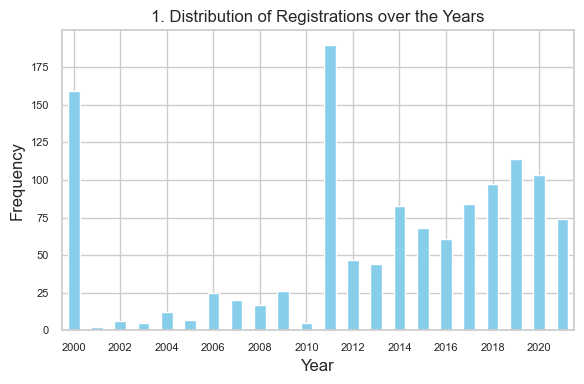

In [313]:
# Plot the distribution of 'DATA_CADASTRO' 
plt.figure(figsize=(6, 4))
ax = df_cad['DATA_CADASTRO'].dt.year.value_counts().sort_index().plot(kind='bar', color='skyblue')
ax.set_title('1. Distribution of Registrations over the Years')
ax.set_xlabel('Year')
ax.set_ylabel('Frequency')
ax.set_xticks(ax.get_xticks()[::2])# Adjust x-axis ticks to show every second year
plt.xticks(rotation=0, size=8)
plt.yticks(size=8)
plt.tight_layout()
plt.show()

    Plot '1. Distribution of Registrations over the Years' shows that registration peaks occurred in 2000 and 2011, with 2000 being the beginning of the historical series. Coincidence or not, these peaks occurred close to global crises: the DotCom Crisis (2000-2002), the Subprime Crisis (2008), and the European Sovereign Debt Crisis (2010-2012).

In [314]:
print('Table "Cadastral"\nPercentage of missing values\n')
for column in df_cad.columns:
    nulls = df_cad[column].isna().sum()
    if nulls != 0:
        percent = 100-(((df_cad.shape[0]- nulls)/df_cad.shape[0])*100)
        print(f'{column} = {percent:.2f}')

Table "Cadastral"
Percentage of missing values

DDD = 16.81
SEGMENTO_INDUSTRIAL = 1.36
DOMINIO_EMAIL = 2.32
PORTE = 3.12


In [315]:
df_cad.isna().sum()

ID_CLIENTE               0
DATA_CADASTRO            0
DDD                    210
SEGMENTO_INDUSTRIAL     17
DOMINIO_EMAIL           29
PORTE                   39
CEP_2_DIG                0
dtype: int64

    We can retrieve information about location from both 'CEP_2_DIG' and 'DDD'. Since column 'CEP_2_DIG' has less missing information, we will start with it.



In [316]:
# Make the data more uniform 
df_cad = df_cad.replace({'PEQUENO': 'Pequeno', 'MEDIO': 'Médio', 'GRANDE': 'Grande'}).copy()

### <span style="color:orange">1.1 Column 'CEP_2_DIG'</span>

In [317]:
df_cad['CEP_2_DIG'] = pd.to_numeric(df_cad['CEP_2_DIG'], errors='coerce')
df_cad['CEP_2_DIG'].unique()

array([65., 77., 48., 89., 62., 19., 38., 26., 55., 87., 37., 22., 13.,
       18., 21., 98., 14., 60., 82., 92., 79., 12., 27., 76., 67., 72.,
       68., 11., 84., 70., 83., 88., 75., 36., 45., 44., 16., 42., 78.,
       31., 41., 35., 51., 30., 86., 25., 29., 17., 23., 20., 93., 64.,
       95., 85., 15., 99., 80., 24., 61., 90., 50., 96., 97., 57., 46.,
       47., 32., 54., 91., 56., 28., 71., 33., 94., 58., 34., 59., 69.,
       74., 40., 49., 43., 66., 39., 73., 81., 53., 52., 63., nan])

In [318]:
# Check the null value in 'CEP_2_DIG'
df_cad[df_cad['CEP_2_DIG'].isna()]

,ID_CLIENTE,DATA_CADASTRO,DDD,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG
934,3903290047715748290,2019-10-07,NaN,Indústria,HOTMAIL,Pequeno,NaN


In [319]:
# Call the function to add the 'STATE' and 'REGION' columns based on 'CEP_2_DIG'
df_cad = utils.add_state_region(df_cad, f'{base_folder}/state_region_info.json')

# Since we created the columns 'ESTADO' and 'REGION', we can drop 'CEP_2_DIG' and 'DDD' and other unecessary columns
df_cad = df_cad.drop(columns=['DDD', 'CEP_2_DIG', 'DOMINIO_EMAIL', 'DATA_CADASTRO']).copy()

# Check the result
df_cad.columns

Index(['ID_CLIENTE', 'SEGMENTO_INDUSTRIAL', 'PORTE', 'ESTADO', 'REGIAO'], dtype='object')

### <span style="color:orange">**1.2 Columns 'REGIAO' & 'ESTADO'**</span>

In [323]:
# Check of records with missing values in 'REGIAO' or 'ESTADO'
df_cad[df_cad['ESTADO'].isna() | df_cad['REGIAO'].isna()]

,ID_CLIENTE,SEGMENTO_INDUSTRIAL,PORTE,ESTADO,REGIAO
934,3903290047715748290,Indústria,Pequeno,NaN,NaN


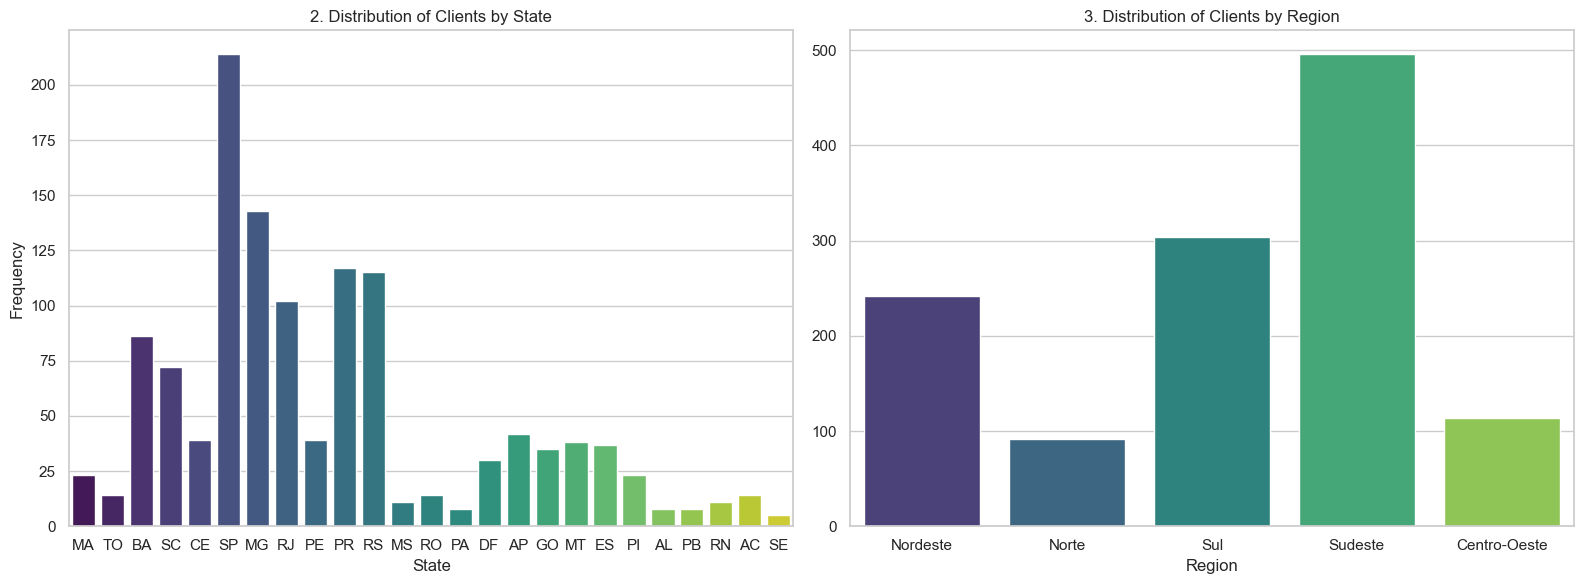

In [330]:
# Create subplots for both plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: SEGMENTO_INDUSTRIAL vs REGIAO
sns.countplot(x='ESTADO', hue='ESTADO', data=df_cad, ax=axes[0], palette='viridis', legend=False)
axes[0].set_title('2. Distribution of Clients by State')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Frequency')

# Plot 2: PORTE vs REGIAO
sns.countplot(x='REGIAO', hue='REGIAO', data=df_cad, ax=axes[1], palette='viridis', legend=False)
axes[1].set_title('3. Distribution of Clients by Region')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Plots 2 and 3 show that the most frequent state is 'SP' and the most frequent region is 'Sudeste'. Since the margin for the 2nd places are quite big, we'll replace the missing record with 'SP' for 'ESTADO' and 'SUDESTE' for 'REGIAO'.

### <span style="color:orange">1.3 Columns 'PORTE' & 'SEGMENTO_INDUSTRIAL'</span>

    Plots 2 and 3 show that the service segment has the highest frequency for all regions and segments and most of the clients are medium-sized.


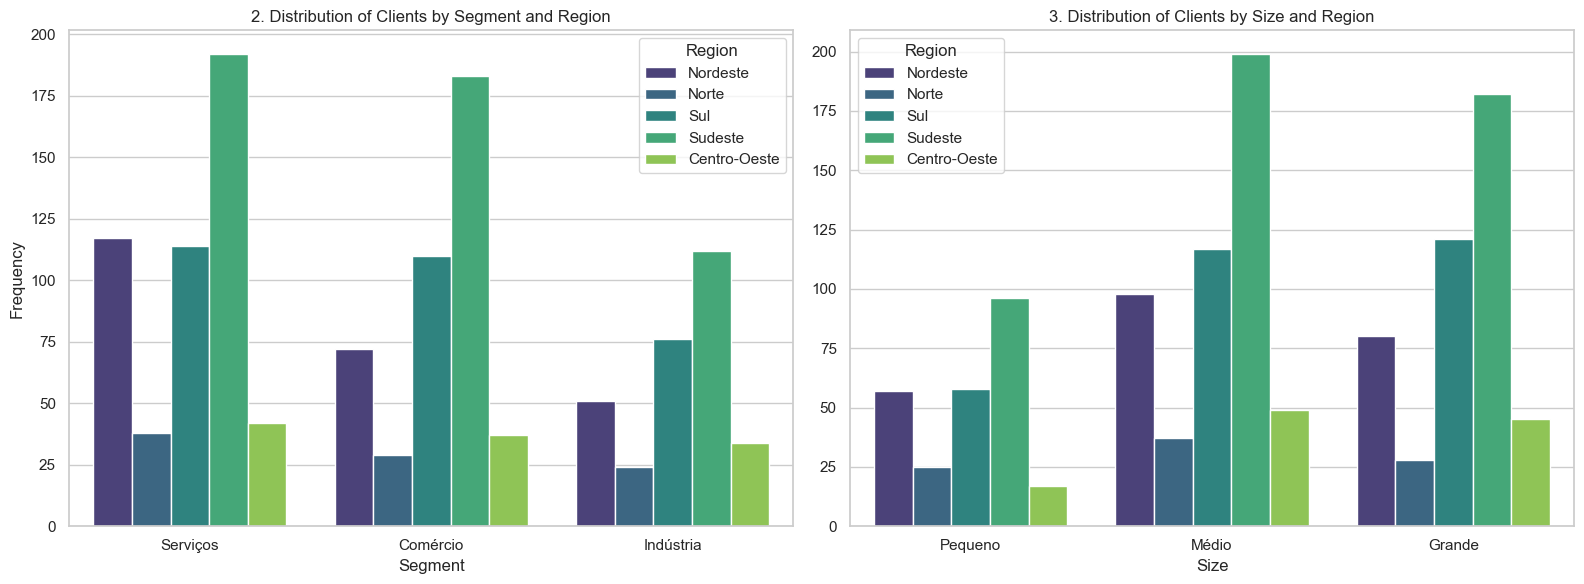

In [296]:
# Create subplots for both plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: SEGMENTO_INDUSTRIAL vs REGIAO
sns.countplot(x='SEGMENTO_INDUSTRIAL', hue='REGIAO', data=df_cad, ax=axes[0], palette='viridis')
axes[0].set_title('2. Distribution of Clients by Segment and Region')
axes[0].set_xlabel('Segment')
axes[0].set_ylabel('Frequency')
axes[0].legend(title='Region')

# Plot 2: PORTE vs REGIAO
sns.countplot(x='PORTE', hue='REGIAO', data=df_cad, ax=axes[1], palette='viridis')
axes[1].set_title('3. Distribution of Clients by Size and Region')
axes[1].set_xlabel('Size')
axes[1].set_ylabel('')
axes[1].legend(title='Region')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [302]:
df_cad['REGIAO'].unique()

array(['Nordeste', 'Norte', 'Sul', 'Sudeste', 'Centro-Oeste', nan],
      dtype=object)

In [301]:
for regiao in df_cad['REGIAO'].unique():
    moda_segmento = df_cad[df_cad['REGIAO'] == regiao]['SEGMENTO_INDUSTRIAL'].mode()[0]
    print(moda_segmento)
    # df_cad.loc[(df_cad['SEGMENTO_INDUSTRIAL'].isna()) & (df_cad['REGIAO'] == regiao), 'SEGMENTO_INDUSTRIAL'] = moda_segmento

Serviços
Serviços
Serviços
Serviços
Serviços


KeyError: 0

In [297]:
# Imput missing values for 'SEGMENTO' based on mode/region
for regiao in df_cad['REGIAO'].unique():
    moda_segmento = df_cad[df_cad['REGIAO'] == regiao]['SEGMENTO_INDUSTRIAL'].mode()
    df_cad.loc[(df_cad['SEGMENTO_INDUSTRIAL'].isna()) & (df_cad['REGIAO'] == regiao), 'SEGMENTO_INDUSTRIAL'] = moda_segmento

# Imput missing values for 'SEGMENTO' based on mode/(region & segment) 
for regiao in df_cad['REGIAO'].unique():
    for segmento in df_cad['SEGMENTO_INDUSTRIAL'].unique():
        moda_porte = df_cad[(df_cad['REGIAO'] == regiao) & (df_cad['SEGMENTO_INDUSTRIAL'] == segmento)]['PORTE'].mode()
        if not moda_porte.empty:
            df_cad.loc[(df_cad['PORTE'].isna()) & (df_cad['REGIAO'] == regiao) & (df_cad['SEGMENTO_INDUSTRIAL'] == segmento), 'PORTE'] = moda_porte[0]


In [298]:
print('Quantidade de dados nulos na base info:')
df_cad.isna().sum()

Quantidade de dados nulos na base info:


ID_CLIENTE              0
SEGMENTO_INDUSTRIAL    17
PORTE                   1
ESTADO                  1
REGIAO                  1
dtype: int64

In [299]:
.k jnbnibjhk

SyntaxError: invalid syntax (4233032726.py, line 1)

In [81]:
for column in df_cad.columns:
    print(f'{column}')
    print(f'{df_cad[column].unique()}\n')

ID_CLIENTE
[1661240395903230676 8274986328479596038  345447888460137901 ...
  957773253650890560 6094038865287329652 1592581784061157609]

SEGMENTO_INDUSTRIAL
['Serviços' 'Comércio' 'Indústria']

PORTE
['Pequeno' 'Médio' 'Grande']

ESTADO
['MA' 'TO' 'BA' 'SC' 'CE' 'SP' 'MG' 'RJ' 'PE' 'PR' 'RS' 'MS' 'RO' 'PA'
 'DF' 'AP' 'GO' 'MT' 'ES' 'PI' 'AL' 'PB' 'RN' 'AC' 'SE']

REGIAO
['Nordeste' 'Norte' 'Sul' 'Sudeste' 'Centro-Oeste']



In [82]:
## Save the cleaned dataframe
# df_cad.to_csv(clean_folder / 'df_cad_clean.csv', index=False)

# 2. Base info

In [83]:
for column in df_info.columns:
    print(f'{column}')
    print(f'{df_info[column].unique()}\n')

ID_CLIENTE
[1661240395903230676 8274986328479596038  345447888460137901 ...
 6893616200284527465 7222128416864635362 1592581784061157609]

SAFRA_REF
['2018-09' '2018-10' '2018-11' '2018-12' '2019-01' '2019-02' '2019-03'
 '2019-04' '2019-05' '2019-06' '2019-07' '2019-08' '2019-09' '2019-10'
 '2019-11' '2019-12' '2020-01' '2020-02' '2020-03' '2020-04' '2020-05'
 '2020-06' '2020-07' '2020-08' '2020-09' '2020-10' '2020-11' '2020-12'
 '2021-01' '2021-02' '2021-03' '2021-04' '2021-05' '2021-06' '2021-07'
 '2021-08' '2021-09' '2021-10' '2021-11' '2021-12']

RENDA_MES_ANTERIOR
[ 16913. 106430. 707439. ... 292698. 106180. 338952.]

NO_FUNCIONARIOS
[ 92. 141.  99.  96. 103. 120.  79.  72. 101. 137. 105.  82. 125. 107.
 153.  97. 115.  84. 128. 122. 132. 100. 123. 121. 106. 116.  95. 109.
  89. 104.  90. 131. 102. 118. 114.  83.  98. 112.  85. 150. 144.  80.
  94. 119. 111.  86. 129. 126. 110.  71.  78. 127. 108.  93. 113. 138.
  87.  81.  75. 139.  88. 117.  60. 133. 130. 135.  77. 134.  73.  91

In [84]:
df_info[utils.get_numeric_cols(df_info)].describe()

,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
count,2.440100e+04,24401.000000
mean,2.885432e+05,117.820540
std,2.114604e+05,21.439451
min,1.050000e+02,0.000000
25%,1.336420e+05,106.000000
50%,2.410160e+05,118.000000
75%,3.922190e+05,131.000000
max,1.682759e+06,198.000000


A tabela acima mostra que NO_FUNCIONARIOS tem valores iguais a zero, o que não faz sentido. Vamos analisar essa coluna para descobrir a melhor forma de tratar esses zeros.

In [85]:
# Identify rows where NO_FUNCIONARIOS is zero
zero_funcionarios = df_info[df_info['NO_FUNCIONARIOS'] == 0]

# Check the total of zeros in NO_FUNCIONARIOS
print(f'Número total de empresas com 0 funcionários:\n{df_info[df_info['ID_CLIENTE'].isin(zero_funcionarios['ID_CLIENTE'])].shape[0]}')

Número total de empresas com 0 funcionários:
224


Como a base info pode ter a mesma empresa mais de uma vez, vamos checar se em alguma observação as empresas com zero têm valor não nulo para número de funcionários. Se a resposta for afirmativa, vamos substituir o zero com o dado mais recente conforme a coluna SAFRA.

In [86]:
# Apply the function to rows with zero NO_FUNCIONARIOS
df_info.loc[df_info['NO_FUNCIONARIOS'] == 0, 'NO_FUNCIONARIOS'] = df_info[df_info['NO_FUNCIONARIOS'] == 0].apply(lambda row: utils.replace_zero_func(df_info, row), axis=1)

# Check the result to ensure zeroes have been replaced
x = df_info[df_info['ID_CLIENTE'].isin(zero_funcionarios['ID_CLIENTE'])].shape[0]

# Check the total of zeros in NO_FUNCIONARIOS again
print(f'Número total de empresas com 0 funcionários:\n{x}')

Número total de empresas com 0 funcionários:
224


Essa primeira alternativa não diminui o número de zeros, então vamos analisar a distribuição dos dados para decidir que método de imputação usar.

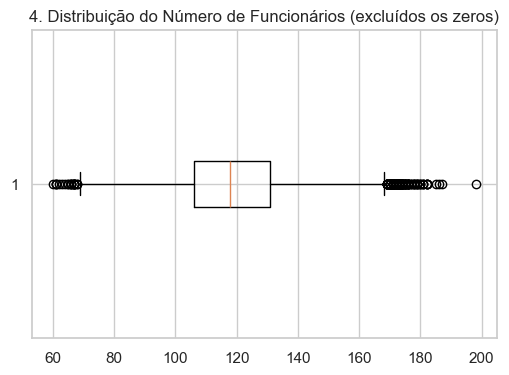

In [87]:
no_zero_employees = df_info[df_info['NO_FUNCIONARIOS']!=0].copy()
# Plot a boxplot for the NO_FUNCIONARIOS column, ignoring zeros
plt.figure(figsize=(6, 4))
plt.boxplot(no_zero_employees['NO_FUNCIONARIOS'], vert=False)
plt.title('4. Distribuição do Número de Funcionários (excluídos os zeros)')
# plt.xlabel('Número de Funcionários')
plt.show()

O boxplot de Distribuição do Número de Funcionários mostra alguns outliers. Neste sentido, usaremos mediana na imputação já que a mesma é menos sensível do que a média em relação a ocorrência de observações extremas.

In [88]:
# Calculate the median of the NO_FUNCIONARIOS column, ignoring zeros
# mean_funcionarios = df[df['NO_FUNCIONARIOS'] != 0]['NO_FUNCIONARIOS'].mean()
median_funcionarios = df_info[df_info['NO_FUNCIONARIOS'] != 0]['NO_FUNCIONARIOS'].median()
print(f'Mediana = {median_funcionarios}')

Mediana = 118.0


In [89]:
# Replace zeros in the NO_FUNCIONARIOS column with the median
df_info0 = df_info.copy()
df_info = df_info.copy()
df_info['NO_FUNCIONARIOS'] = df_info['NO_FUNCIONARIOS'].replace(0, median_funcionarios)

# Verify the replacement by checking if there are still any zeros
zero_count_after_replacement = (df_info['NO_FUNCIONARIOS'] == 0).sum()
zero_count_after_replacement

np.int64(0)

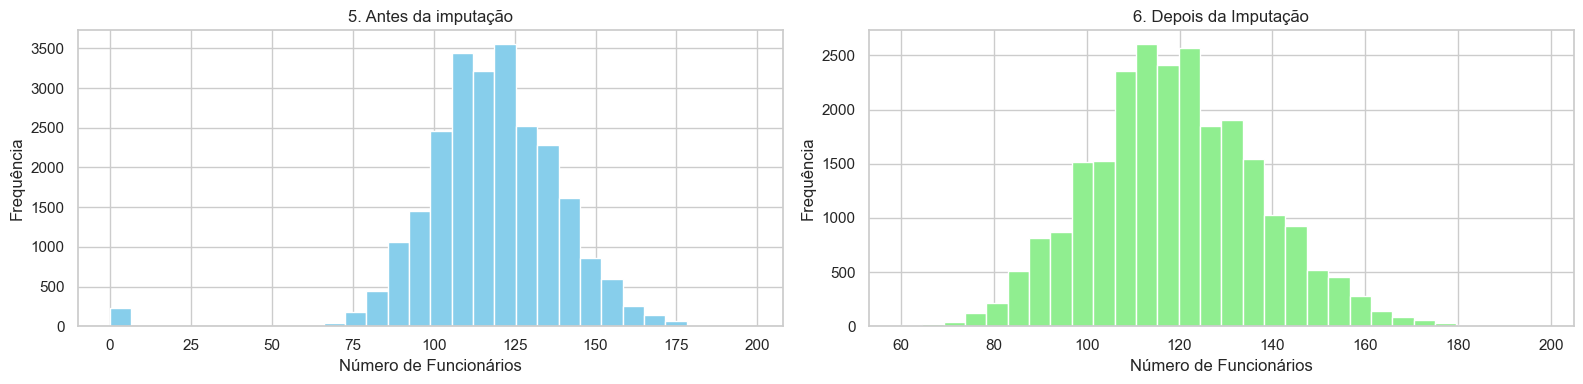

In [90]:
# Plot histograms for comparison before and after the imputation of zeros
plt.figure(figsize=(16, 4))

# Before imputation (replace zeros back to see original distribution)
plt.subplot(1, 2, 1)
plt.hist(df_info0['NO_FUNCIONARIOS'], bins=30, color='skyblue')
plt.title('5. Antes da imputação')
plt.xlabel('Número de Funcionários')
plt.ylabel('Frequência')

# After imputation
plt.subplot(1, 2, 2)
plt.hist(df_info['NO_FUNCIONARIOS'], bins=30, color='lightgreen')
plt.title('6. Depois da Imputação')
plt.xlabel('Número de Funcionários')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

In [91]:
# Group the data by 'ID_CLIENTE' and calculate the average for 'RENDA_MES_ANTERIOR' and 'NO_FUNCIONARIOS'
# aveg_info = df_info.groupby('ID_CLIENTE').agg({
#     'RENDA_MES_ANTERIOR': 'mean',
#     'NO_FUNCIONARIOS': 'mean'
# }).reset_index()

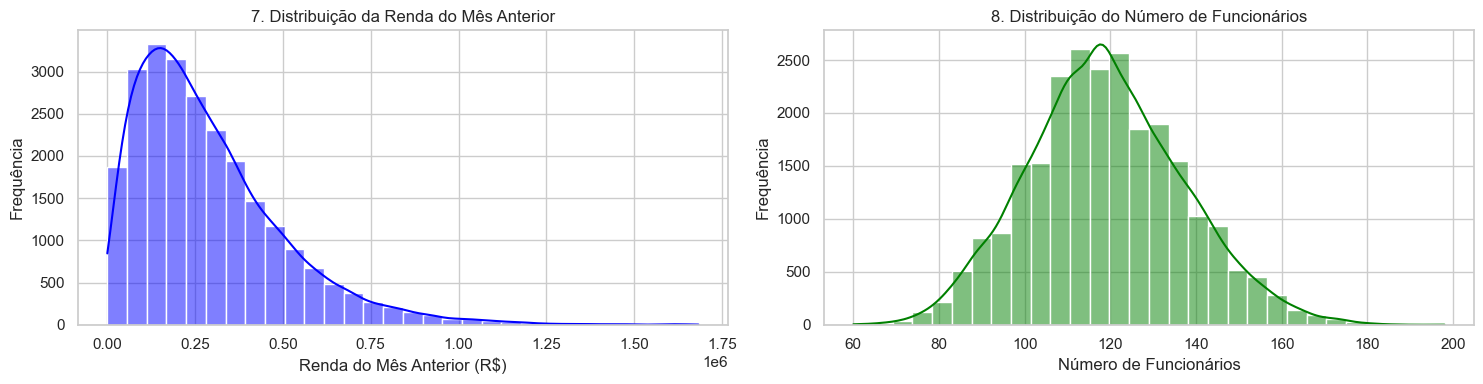

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Create a histogram for RENDA_MES_ANTERIOR
sns.histplot(df_info['RENDA_MES_ANTERIOR'], bins=30, color='blue', kde=True, stat='count', ax=axes[0])
axes[0].set_title('7. Distribuição da Renda do Mês Anterior')
axes[0].set_xlabel('Renda do Mês Anterior (R$)')
axes[0].set_ylabel('Frequência')

# Create a histogram for NO_FUNCIONARIOS
sns.histplot(df_info['NO_FUNCIONARIOS'], bins=30, color='green', kde=True, stat='count', ax=axes[1])
axes[1].set_title('8. Distribuição do Número de Funcionários')
axes[1].set_xlabel('Número de Funcionários')
axes[1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

In [93]:
df_info['RENDA_MES_ANTERIOR_LOG'] = np.log1p(df_info['RENDA_MES_ANTERIOR'])

In [94]:
# print(f'{clean_folder}')

# Save the cleaned dataframe
# df_info.to_csv(clean_folder / 'df_info_clean.csv', index=False)
# pd.read_csv(clean_folder / 'df_info_clean.csv')

# 3. Base Pagamentos (treino) e Base Pagamentos (teste)

In [95]:
df_pag_train[['VALOR_A_PAGAR', 'TAXA']].describe()

,VALOR_A_PAGAR,TAXA
count,7.741400e+04,77414.000000
mean,4.656546e+04,6.789623
std,4.633892e+04,1.798225
min,1.000000e-01,4.990000
25%,1.875275e+04,5.990000
50%,3.475135e+04,5.990000
75%,6.088421e+04,6.990000
max,4.400000e+06,11.990000


In [96]:
df_pag_test[['VALOR_A_PAGAR', 'TAXA']].describe()

,VALOR_A_PAGAR,TAXA
count,12275.000000,12275.000000
mean,65899.369914,6.807271
std,55874.481691,1.835351
min,6.900000,4.990000
25%,26718.375000,5.990000
50%,49705.010000,5.990000
75%,87163.295000,6.990000
max,830000.000000,11.990000


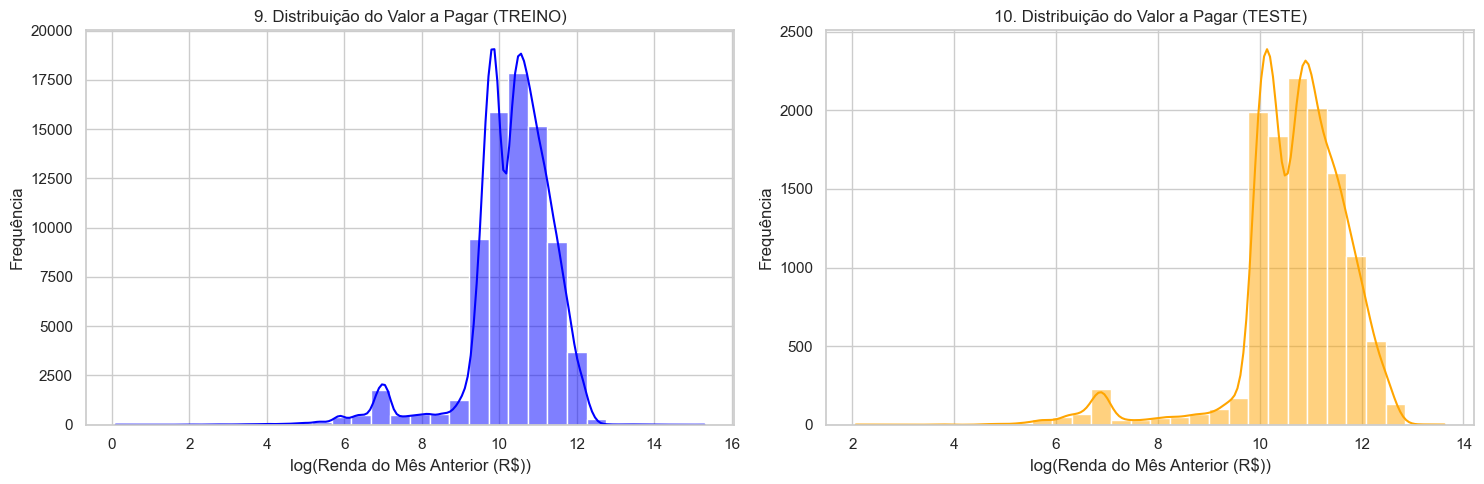

In [97]:
# Apply log transformation (adding a small value to avoid log(0))
df_pag_train['VALOR_A_PAGAR_LOG'] = np.log1p(df_pag_train['VALOR_A_PAGAR'])
df_pag_test['VALOR_A_PAGAR_LOG'] = np.log1p(df_pag_test['VALOR_A_PAGAR'])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the distribution 'VALOR_A_PAGAR' train and test
sns.histplot(df_pag_train['VALOR_A_PAGAR_LOG'], bins=30, color='blue', kde=True, stat='count', ax=axes[0])
axes[0].set_title('9. Distribuição do Valor a Pagar (TREINO)')
axes[0].set_xlabel('log(Renda do Mês Anterior (R$))')
axes[0].set_ylabel('Frequência')
sns.histplot(df_pag_test['VALOR_A_PAGAR_LOG'], bins=30, color='orange', kde=True, stat='count', ax=axes[1])
axes[1].set_title('10. Distribuição do Valor a Pagar (TESTE)')
axes[1].set_xlabel('log(Renda do Mês Anterior (R$))')
axes[1].set_ylabel('Frequência')

plt.tight_layout(h_pad=3)
plt.show()

In [98]:
df_pag_train.columns

Index(['ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO',
       'DATA_VENCIMENTO', 'VALOR_A_PAGAR', 'TAXA', 'VALOR_A_PAGAR_LOG'],
      dtype='object')

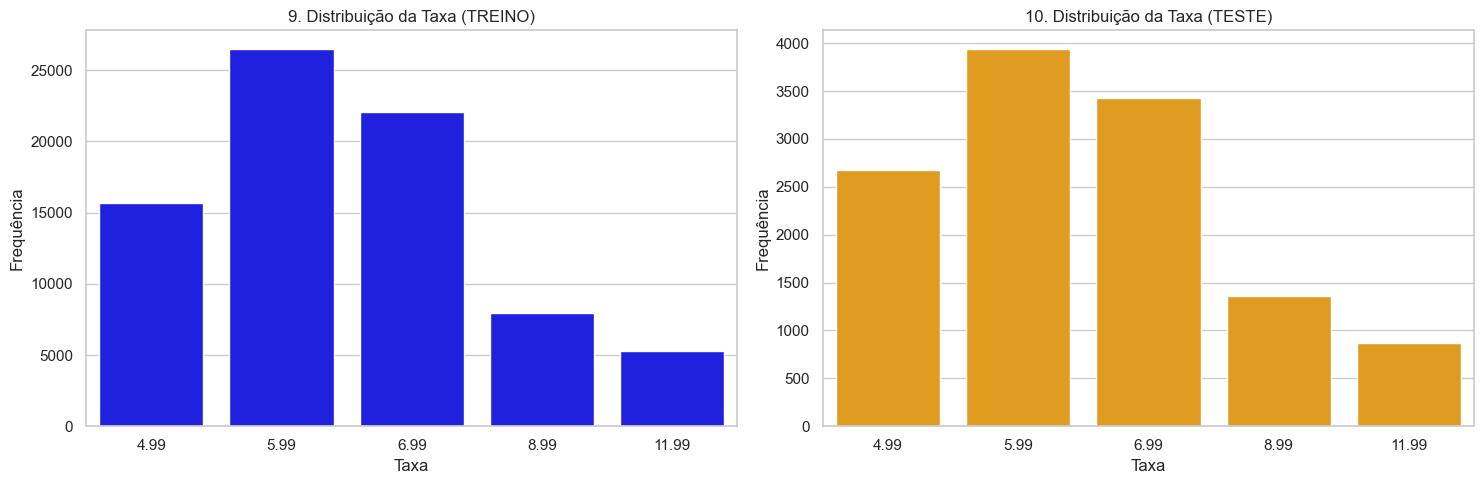

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de barras para a distribuição da 'TAXA' (TREINO)
sns.countplot(data=df_pag_train, x='TAXA', color='blue', ax=axes[0])
axes[0].set_title('9. Distribuição da Taxa (TREINO)')
axes[0].set_xlabel('Taxa')
axes[0].set_ylabel('Frequência')

# Gráfico de barras para a distribuição da 'TAXA' (TESTE)
sns.countplot(data=df_pag_test, x='TAXA', color='orange', ax=axes[1])
axes[1].set_title('10. Distribuição da Taxa (TESTE)')
axes[1].set_xlabel('Taxa')
axes[1].set_ylabel('Frequência')

# Ajustar o espaçamento entre os subplots
plt.tight_layout(h_pad=3)
plt.show()

Indimplência é calculada com base na nos dias de atraso.

In [100]:
df_pag_train['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(df_pag_train['DATA_EMISSAO_DOCUMENTO'])
df_pag_train['DATA_VENCIMENTO'] = pd.to_datetime(df_pag_train['DATA_VENCIMENTO'])
df_pag_train['DATA_PAGAMENTO'] = pd.to_datetime(df_pag_train['DATA_PAGAMENTO'])
# df_pag_train['SAFRA_REF'] = pd.to_datetime(df_pag_train['SAFRA_REF'])

df_pag_test['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(df_pag_test['DATA_EMISSAO_DOCUMENTO'])
df_pag_test['DATA_VENCIMENTO'] = pd.to_datetime(df_pag_test['DATA_VENCIMENTO'])
# df_pag_test['SAFRA_REF'] = pd.to_datetime(df_pag_test['SAFRA_REF'])

In [101]:
# Create the 'INADIMPLENTE' target variable: difference >= 5 days indicates default
df_pag_train['DIAS_ATRASO'] = (df_pag_train['DATA_PAGAMENTO'] - df_pag_train['DATA_VENCIMENTO']).dt.days
df_pag_train['INADIMPLENTE'] = df_pag_train['DIAS_ATRASO'].apply(lambda x: 1 if x >= 5 else 0)

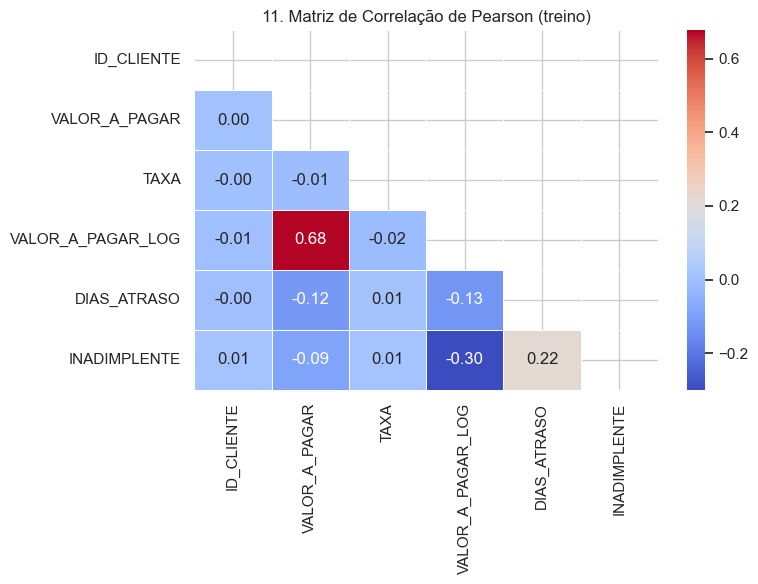

In [102]:
# Selecting only numeric columns
# numeric_cols_test = df_pag_test.select_dtypes(include=['float64', 'int64']).columns
# pear_corr_test = df_pag_test[numeric_cols_test].corr()
numeric_cols_train = df_pag_train.select_dtypes(include=['float64', 'int64']).columns
pear_corr_train = df_pag_train[numeric_cols_train].corr()

plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(pear_corr_train, dtype=bool))
sns.heatmap(pear_corr_train, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('11. Matriz de Correlação de Pearson (treino)')
plt.tight_layout()
plt.show()

Intensidade da correlação:

- Forte: 0.7 a 0.9 positivo ou negativo 
- Moderada: 0.5 a 0.7 positivo ou negativo 
- Fraca: 0.3 a 0.5 positivo ou negativo 
- Desprezível: 0 a 0.3 positivo ou negativo

*Importante lembrar que a correlação de Pearson é uma medida de correlação LINEAR.*

O gráfico '11. Matriz de Correlação de Pearson (treino)' mostra que o log do valor a pagar tem uma correlacão negativa fraca com a inadimplência. 

In [103]:
# # print(f'{clean_folder}')

# # Save the cleaned dataframe
# df_pag_train.to_csv(clean_folder / 'df_pag_train_clean.csv', index=False)
# df_pag_test.to_csv(clean_folder / 'df_pag_test_clean.csv', index=False)
# pd.read_csv(clean_folder / 'df_pag_train_clean.csv')
# pd.read_csv(clean_folder / 'df_pag_test_clean.csv')

# 4. Juntando Base Info e Base Cad

In [104]:
# Merge Base Info and Base Cadastral on 'ID_CLIENTE' with indicator=True
df_info_cad_OUTER = pd.merge(df_info, df_cad, on='ID_CLIENTE', how='outer', indicator=True).copy()

# Check the breakdown of where the data comes from
# df_info_cad_OUTER['_merge'].value_counts()

n_left = df_info_cad_OUTER[df_info_cad_OUTER['_merge']=='left_only'].shape[0]
n_total_info = df_info_cad_OUTER.shape[0]
print(f'Um aproximadamente {((n_total_info-n_left)/n_total_info):.2f}% das empresas em Base Info não foram cadastradas.')

Um aproximadamente 0.99% das empresas em Base Info não foram cadastradas.


Como o percentual de empresas não cadastradas foi baixo, vamos desconsiderá-las.

In [105]:
# Merge Base Info and Base Cadastral on 'ID_CLIENTE'
df_info_cad = pd.merge(df_info, df_cad, on='ID_CLIENTE', how='inner').copy()

df_info_cad.isna().sum()

ID_CLIENTE                0
SAFRA_REF                 0
RENDA_MES_ANTERIOR        0
NO_FUNCIONARIOS           0
RENDA_MES_ANTERIOR_LOG    0
SEGMENTO_INDUSTRIAL       0
PORTE                     0
ESTADO                    0
REGIAO                    0
dtype: int64

In [106]:
df_info_cad['RENDA_MES_ANTERIOR'].describe()

count    2.414000e+04
mean     2.910370e+05
std      2.109007e+05
min      1.050000e+02
25%      1.362932e+05
50%      2.434230e+05
75%      3.939170e+05
max      1.682759e+06
Name: RENDA_MES_ANTERIOR, dtype: float64

In [107]:
# print(f'{clean_folder}')

## Save the cleaned dataframe
# df_info_cad.to_csv(clean_folder / 'df_info_cad_merge.csv', index=False)
# pd.read_csv(clean_folder / 'df_info_cad_merge.csv')

In [108]:
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=df_info_cad, x='PORTE', y='NO_FUNCIONARIOS', hue="SEGMENTO_INDUSTRIAL", fill=False, gap=.1)
# plt.xlabel('Porte')
# plt.ylabel('Número de Funcionários')
# plt.legend(title='', bbox_to_anchor=(1.19, 1.04))
# plt.show()

# plt.figure(figsize=(10, 6))
# sns.boxplot(data=df_info_cad, x='PORTE', y='RENDA_MES_ANTERIOR', hue="SEGMENTO_INDUSTRIAL", fill=False, gap=.1)
# plt.xlabel('Porte')
# plt.ylabel('Renda')
# plt.legend(title='', bbox_to_anchor=(1.19, 1.04))
# plt.show()

# plt.figure(figsize=(10, 6))
# sns.boxplot(data=df_info_cad, x='REGIAO', y='RENDA_MES_ANTERIOR', hue="SEGMENTO_INDUSTRIAL", fill=False, gap=.1)
# plt.xlabel('Região')
# plt.ylabel('Renda')
# plt.legend(title='', bbox_to_anchor=(1.19, 1.04))
# plt.show()

In [109]:
df_info_cad.columns

Index(['ID_CLIENTE', 'SAFRA_REF', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS',
       'RENDA_MES_ANTERIOR_LOG', 'SEGMENTO_INDUSTRIAL', 'PORTE', 'ESTADO',
       'REGIAO'],
      dtype='object')

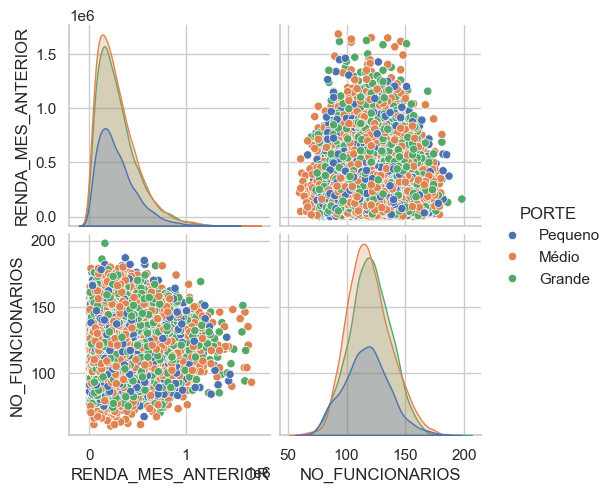

In [110]:
sns.pairplot(df_info_cad, hue='PORTE', vars=['RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS'])
plt.show()

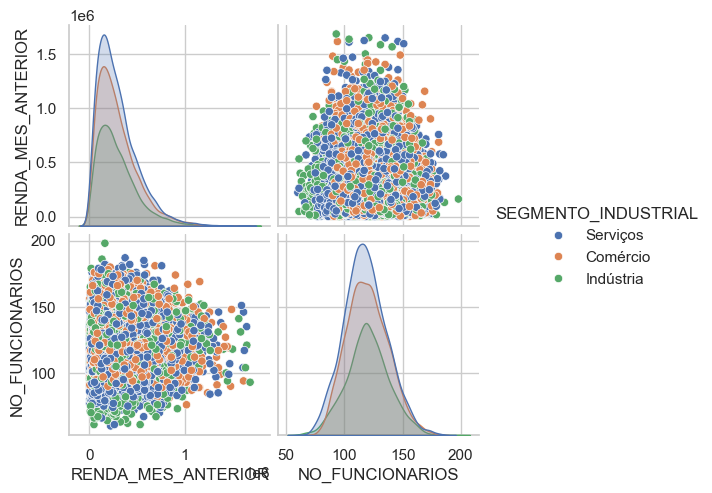

In [111]:
sns.pairplot(df_info_cad, hue='SEGMENTO_INDUSTRIAL', vars=['RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS'])
plt.show()

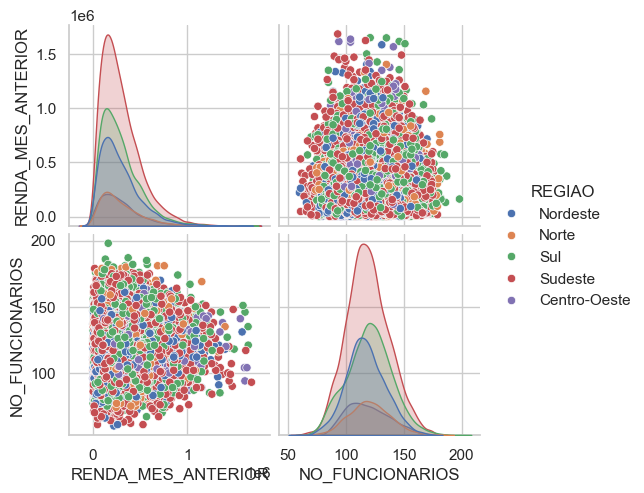

In [112]:
sns.pairplot(df_info_cad, hue='REGIAO', vars=['RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS'])
plt.show()

In [113]:
# aveg_info = df_info_cad.groupby(['REGIAO', 'PORTE', 'SEGMENTO_INDUSTRIAL']).agg({
#     'RENDA_MES_ANTERIOR': 'mean',
#     'NO_FUNCIONARIOS': 'mean'
# }).reset_index()
# # aveg_info

In [114]:
df_info_cad.columns

Index(['ID_CLIENTE', 'SAFRA_REF', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS',
       'RENDA_MES_ANTERIOR_LOG', 'SEGMENTO_INDUSTRIAL', 'PORTE', 'ESTADO',
       'REGIAO'],
      dtype='object')

In [115]:
df_test = pd.merge(df_info_cad, df_pag_test, on=['ID_CLIENTE', 'SAFRA_REF'], how='inner', indicator=True)
df_test.isna().sum()

ID_CLIENTE                0
SAFRA_REF                 0
RENDA_MES_ANTERIOR        0
NO_FUNCIONARIOS           0
RENDA_MES_ANTERIOR_LOG    0
SEGMENTO_INDUSTRIAL       0
PORTE                     0
ESTADO                    0
REGIAO                    0
DATA_EMISSAO_DOCUMENTO    0
DATA_VENCIMENTO           0
VALOR_A_PAGAR             0
TAXA                      0
VALOR_A_PAGAR_LOG         0
_merge                    0
dtype: int64

In [116]:
# print(f'{clean_folder}')

# # Save the cleaned dataframe
# df_test.to_csv(clean_folder / 'df_test.csv', index=False)

In [117]:
df_train = pd.merge(df_info_cad, df_pag_train, on=['ID_CLIENTE', 'SAFRA_REF'], how='right')
df_train.isna().sum()

ID_CLIENTE                   0
SAFRA_REF                    0
RENDA_MES_ANTERIOR        4096
NO_FUNCIONARIOS           4096
RENDA_MES_ANTERIOR_LOG    4096
SEGMENTO_INDUSTRIAL       4096
PORTE                     4096
ESTADO                    4096
REGIAO                    4096
DATA_EMISSAO_DOCUMENTO       0
DATA_PAGAMENTO               0
DATA_VENCIMENTO              0
VALOR_A_PAGAR                0
TAXA                         0
VALOR_A_PAGAR_LOG            0
DIAS_ATRASO                  0
INADIMPLENTE                 0
dtype: int64

In [118]:
df_train = df_train.copy()

numeric_cols = df_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_train.select_dtypes(include=['object']).columns

num_imputer = SimpleImputer(strategy='median')
df_train[numeric_cols] = num_imputer.fit_transform(df_train[numeric_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
df_train[categorical_cols] = cat_imputer.fit_transform(df_train[categorical_cols])

In [119]:
# print(f'{clean_folder}')

# # Save the cleaned dataframe
# df_test.to_csv(clean_folder / 'df_test.csv', index=False)

In [120]:
df_train.isna().sum()

ID_CLIENTE                0
SAFRA_REF                 0
RENDA_MES_ANTERIOR        0
NO_FUNCIONARIOS           0
RENDA_MES_ANTERIOR_LOG    0
SEGMENTO_INDUSTRIAL       0
PORTE                     0
ESTADO                    0
REGIAO                    0
DATA_EMISSAO_DOCUMENTO    0
DATA_PAGAMENTO            0
DATA_VENCIMENTO           0
VALOR_A_PAGAR             0
TAXA                      0
VALOR_A_PAGAR_LOG         0
DIAS_ATRASO               0
INADIMPLENTE              0
dtype: int64

In [121]:
df_train = utils.consistent_dates(df_train, test=False).copy()
df_test = utils.consistent_dates(df_test, test=True).copy()

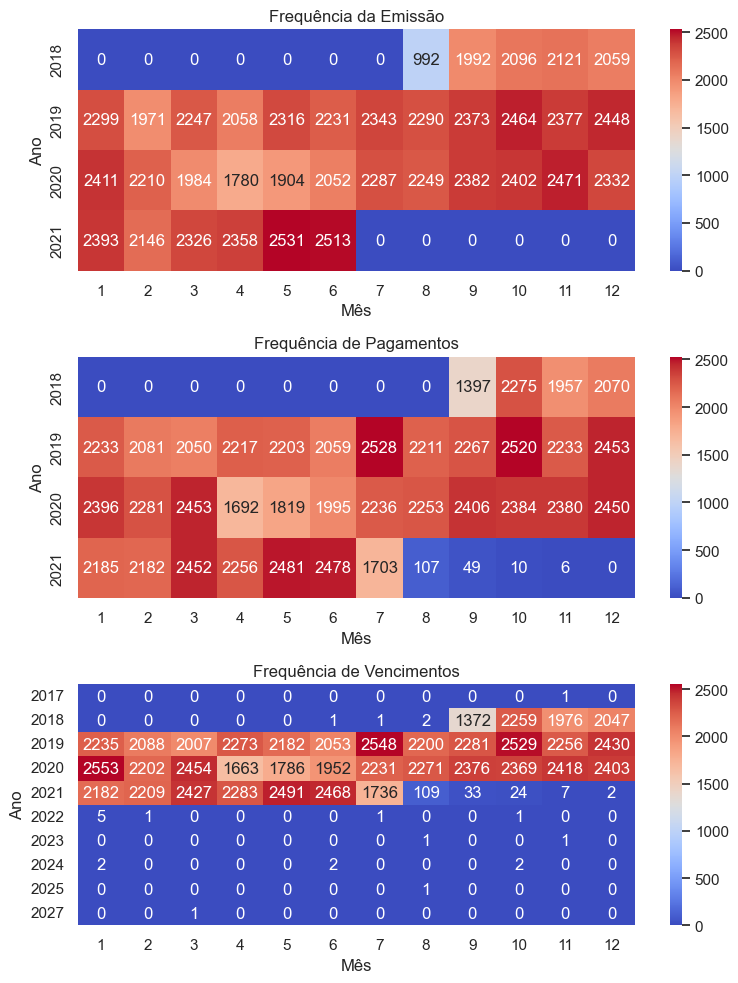

In [122]:
data = df_train.copy()

# Extract year and month from 'DATA_EMISSAO_DOCUMENTO' and 'DATA_VENCIMENTO'
data['emissao_year'] = data['DATA_EMISSAO_DOCUMENTO'].dt.year
data['emissao_month'] = data['DATA_EMISSAO_DOCUMENTO'].dt.month
data['vencimento_year'] = data['DATA_VENCIMENTO'].dt.year
data['vencimento_month'] = data['DATA_VENCIMENTO'].dt.month
data['pagamento_year'] = data['DATA_PAGAMENTO'].dt.year
data['pagamento_month'] = data['DATA_PAGAMENTO'].dt.month

# Create pivot tables for each date type
heatmap_emissao = data.pivot_table(index='emissao_year', columns='emissao_month', aggfunc='size', fill_value=0)
heatmap_vencimento = data.pivot_table(index='vencimento_year', columns='vencimento_month', aggfunc='size', fill_value=0)
heatmap_pagamento = data.pivot_table(index='pagamento_year', columns='pagamento_month', aggfunc='size', fill_value=0)

# Plotting the 3 heatmaps as subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

# Heatmap for DATA_EMISSAO_DOCUMENTO
sns.heatmap(heatmap_emissao, cmap="coolwarm", annot=True, fmt="d", ax=axes[0])
axes[0].set_title('Frequência da Emissão')
axes[0].set_xlabel('Mês')
axes[0].set_ylabel('Ano')

# Heatmap for DATA_PAGAMENTO
sns.heatmap(heatmap_pagamento, cmap="coolwarm", annot=True, fmt="d", ax=axes[1])
axes[1].set_title('Frequência de Pagamentos')
axes[1].set_xlabel('Mês')
axes[1].set_ylabel('Ano')

# Heatmap for DATA_VENCIMENTO
sns.heatmap(heatmap_vencimento, cmap="coolwarm", annot=True, fmt="d", ax=axes[2])
axes[2].set_title('Frequência de Vencimentos')
axes[2].set_xlabel('Mês')
axes[2].set_ylabel('Ano')

plt.tight_layout()
plt.show()

A frequência de pagamentos e vencimentos ao longo do tempo parece bem próxima. Isso provalmente significa que, nesse banco de dados, os clientes pagam perto do vencimento.

In [123]:
# print(f'{clean_folder}')

# Save the cleaned dataframe
df_train.to_csv(clean_folder / 'df_train0.csv', index=False)
df_test.to_csv(clean_folder / 'df_test0.csv', index=False)

KeyboardInterrupt: 